In [1]:
#type = Ignore
#Importing packages
import torch
import torch.nn as nn
import torch.optim as optim
from AEModel import AE, MyDataset
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


# Reading Dataset

In [2]:
#Read files
gene_df= pd.read_csv("../../data/master_gene_df.csv",encoding = "UTF-8")
cnv_df = pd.read_csv("../../data/master_cnv_df.csv",encoding = "UTF-8")
label_df = pd.read_csv("../../data/final_labels.csv")


In [3]:
cnv_df = cnv_df.merge(label_df[['Case_ID_Final','File ID']], left_on='file_name',right_on = 'File ID', how = 'left')
cnv_df.drop(columns=['File ID','file_name'],inplace = True)

gene_df = gene_df.merge(label_df[['Case_ID_Final','File ID']], left_on='file_name',right_on = 'File ID', how = 'left')
gene_df.drop(columns=['File ID','file_name'],inplace = True)

In [4]:
features_df = pd.merge(left=cnv_df, right=gene_df, on='Case_ID_Final')
cases = features_df.pop('Case_ID_Final')
features_df.insert(0,'case_id',cases)
features_df.head()

,case_id,OR4F5_x,OR4F29_x,OR4F16_x,SAMD11_x,NOC2L_x,KLHL17_x,PLEKHN1_x,PERM1_x,HES4_x,...,DHX34_y,XAGE1B_y,ARL8A_y,KCTD8_y,SLX1B_y,CPNE6_y,XYLB_y,PKN3_y,RGS1_y,PGK1_y
0,TCGA-33-4582,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,17.0345,0.0000,69.3370,0.0000,0.0000,0.0090,12.0017,3.3554,20.8139,438.9808
1,TCGA-LA-A7SW,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,36.3901,0.2246,102.4349,1.7566,0.0645,0.0265,5.4715,36.4585,10.6996,276.3415
2,TCGA-43-5670,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,23.2041,0.0000,72.1953,0.0000,0.0479,0.0197,1.9572,9.5935,7.7148,342.4987
3,TCGA-21-5782,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,17.6639,0.1635,72.4760,0.8953,0.0000,0.8870,4.6417,15.3004,13.2821,718.7201
4,TCGA-22-4601,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,29.5580,0.0000,111.5538,0.0000,0.0538,0.0000,7.7219,14.1261,17.6472,416.1310


In [5]:
# DataLoader is used to load the dataset for training
pd_train_dataset, pd_test_dataset = train_test_split(features_df.iloc[:,1:], test_size=0.2)

X_train_sc = StandardScaler().fit_transform(pd_train_dataset)

X_test_sc = StandardScaler().fit_transform(pd_test_dataset)

X_full_sc = StandardScaler().fit_transform(features_df.iloc[:,1:])

In [6]:
data_train = MyDataset(X_train_sc)
data_test = MyDataset(X_test_sc)
data_full = MyDataset(X_full_sc)

In [7]:
train_loader=DataLoader(data_train, batch_size=50, shuffle=False)
test_loader = DataLoader(data_test, batch_size=50)

In [8]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape = len(X_train_sc[0])).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

In [9]:
losses_train = []
losses_val = []

epochs=400
for epoch in range(epochs):
    model.train()
    loss = 0
    for batch_features in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        lol, outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    losses_train.append(loss)


    #For Valid Loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            code, outputs = model(batch)
            loss_val =criterion(outputs, batch)
            val_loss += loss_val.item()

    val_loss = val_loss / len(test_loader)
    losses_val.append(val_loss)


    # display the epoch training loss
    print("epoch : {}/{}, train_loss = {:.6f}".format(epoch + 1, epochs, loss))
    print("epoch : {}/{}, val_loss = {:.6f}".format(epoch + 1, epochs, val_loss))

epoch : 1/400, train_loss = 1.488519
epoch : 1/400, val_loss = 1.268210
epoch : 2/400, train_loss = 1.089929
epoch : 2/400, val_loss = 1.203298
epoch : 3/400, train_loss = 0.981583
epoch : 3/400, val_loss = 0.975801
epoch : 4/400, train_loss = 0.916656
epoch : 4/400, val_loss = 0.866326
epoch : 5/400, train_loss = 0.861270
epoch : 5/400, val_loss = 0.829668
epoch : 6/400, train_loss = 0.813959
epoch : 6/400, val_loss = 0.797318
epoch : 7/400, train_loss = 0.773432
epoch : 7/400, val_loss = 0.776089
epoch : 8/400, train_loss = 0.737133
epoch : 8/400, val_loss = 0.761105
epoch : 9/400, train_loss = 0.706941
epoch : 9/400, val_loss = 0.732441
epoch : 10/400, train_loss = 0.678627
epoch : 10/400, val_loss = 0.713061
epoch : 11/400, train_loss = 0.653937
epoch : 11/400, val_loss = 0.690845
epoch : 12/400, train_loss = 0.630178
epoch : 12/400, val_loss = 0.678003
epoch : 13/400, train_loss = 0.610052
epoch : 13/400, val_loss = 0.672499
epoch : 14/400, train_loss = 0.593126
epoch : 14/400, va

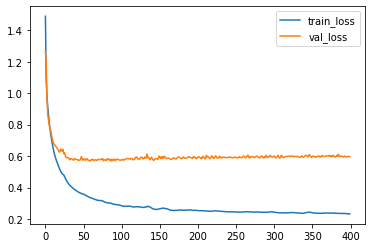

In [11]:
plt.plot(losses_train, label = 'train_loss')
plt.plot(losses_val, label = 'val_loss')
plt.legend()
plt.savefig("../../Figures/AE_gene_cnv.png", dpi = 400)

In [12]:
# Full Gene Autoencoder Taining

data_full = MyDataset(X_full_sc)
full_loader = DataLoader(data_full, batch_size=50)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AE(input_shape = len(X_full_sc[0])).to(device)
optimizer = optim.Adam(model.parameters(),lr=1e-3)
criterion = nn.MSELoss()



In [13]:
losses_train_final = []

epochs=80
for epoch in range(epochs):
    model.train()
    loss = 0
    for batch_features in full_loader:
        batch_features = batch_features.to(device)
        
        optimizer.zero_grad()
        
        code, outputs = model(batch_features)
        
        train_loss = criterion(outputs, batch_features)
        
        train_loss.backward()
        
        optimizer.step()
        
        loss += train_loss.item()
    
    loss = loss / len(train_loader)
    losses_train_final.append(loss)

    print("epoch : {}/{}, train_loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/80, train_loss = 1.785536
epoch : 2/80, train_loss = 1.304665
epoch : 3/80, train_loss = 1.176756
epoch : 4/80, train_loss = 1.093735
epoch : 5/80, train_loss = 1.020123
epoch : 6/80, train_loss = 0.955296
epoch : 7/80, train_loss = 0.900209
epoch : 8/80, train_loss = 0.856856
epoch : 9/80, train_loss = 0.821656
epoch : 10/80, train_loss = 0.792760
epoch : 11/80, train_loss = 0.764800
epoch : 12/80, train_loss = 0.740721
epoch : 13/80, train_loss = 0.719580
epoch : 14/80, train_loss = 0.700032
epoch : 15/80, train_loss = 0.681254
epoch : 16/80, train_loss = 0.665278
epoch : 17/80, train_loss = 0.651479
epoch : 18/80, train_loss = 0.636396
epoch : 19/80, train_loss = 0.622839
epoch : 20/80, train_loss = 0.611078
epoch : 21/80, train_loss = 0.599934
epoch : 22/80, train_loss = 0.589722
epoch : 23/80, train_loss = 0.579130
epoch : 24/80, train_loss = 0.570061
epoch : 25/80, train_loss = 0.561771
epoch : 26/80, train_loss = 0.554958
epoch : 27/80, train_loss = 0.546107
epoch : 28

In [14]:
data = torch.tensor(X_full_sc,dtype=torch.float32)
model.eval()
with torch.no_grad():
    out,out2 = model(data)

In [15]:
latent_df = pd.DataFrame(out)
latent_df.insert(0,'case_id',features_df['case_id'])
latent_df

,case_id,0,1,2,3,4,5,6,7,8,...,118,119,120,121,122,123,124,125,126,127
0,TCGA-33-4582,-0.538320,1.032815,-0.207708,0.828670,-0.533079,1.257552,-0.617863,1.119022,-0.152546,...,-0.655609,-0.711586,-0.698807,1.450487,-0.447062,-0.620233,0.452437,-0.694994,-0.713119,-0.344749
1,TCGA-LA-A7SW,1.959446,-0.998570,0.372400,-0.752460,-0.533079,2.197323,-0.617863,-0.551743,-0.643232,...,-0.655609,-0.711586,-0.698807,4.055389,1.378998,-0.067373,2.029083,2.765881,-0.707433,-0.304322
2,TCGA-43-5670,0.832612,1.379605,-0.849680,-0.446544,-0.533079,-0.724448,-0.617863,1.812993,0.738104,...,-0.411734,-0.297049,1.678690,1.570264,0.516068,0.069641,1.477633,0.332023,-0.713119,-0.344749
3,TCGA-21-5782,6.541538,-0.998570,-0.849680,-0.752460,-0.533079,-0.738057,-0.239469,4.893093,3.645806,...,-0.655609,-0.711586,0.407032,-0.765153,-0.695914,-0.620233,3.810906,-0.694994,-0.713119,-0.088886
4,TCGA-22-4601,0.420577,-0.998570,-0.849680,-0.752460,-0.533079,-0.738057,1.990268,-0.394083,-0.643232,...,-0.595246,-0.676838,1.811497,-0.765153,-0.695914,-0.620233,-0.754544,0.549223,0.589029,-0.344749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949,TCGA-58-8388,4.492478,-0.998570,-0.849680,1.445392,-0.533079,-0.738057,2.077010,2.291249,-0.643232,...,-0.655609,-0.711586,6.711696,-0.765153,-0.695914,-0.620233,-0.754544,1.866920,2.036840,-0.344749
950,TCGA-77-A5GB,-0.004110,-0.998570,-0.849680,-0.752460,-0.533079,-0.738057,-0.617863,0.256559,-0.643232,...,-0.655609,-0.711586,-0.698807,-0.765153,-0.380807,-0.620233,-0.581701,-0.694994,0.200771,-0.344749
951,TCGA-55-6543,-0.347010,-0.216690,-0.849680,-0.266531,-0.533079,-0.738057,-0.617863,0.505401,0.980330,...,-0.655609,-0.711586,-0.698807,-0.126764,-0.695914,0.260744,1.484166,0.442391,-0.307955,-0.344749
952,TCGA-77-A5G3,-0.538320,0.039443,1.119696,2.052179,-0.088726,2.116628,-0.617863,-0.778814,2.570894,...,2.063605,0.958087,-0.698807,1.971468,0.556211,-0.179993,-0.754544,2.736202,-0.713119,1.657057


In [16]:
latent_df.to_csv("../../data/gene_cnv_df_128.csv", index=False)